# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
    
data, attrs = fetch_lfw_dataset()

In [3]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [4]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)

X_train = X_train/255
X_val = X_val/255

In [77]:
def present(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.9, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
 
      
  


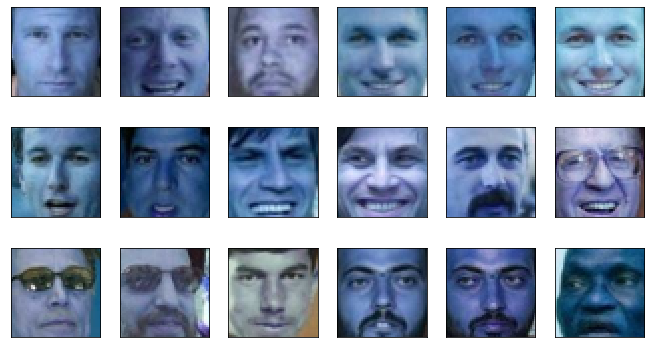

In [78]:
present(X_train, image_h, image_w)


# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [7]:
import theano
import theano.tensor as T
from theano.tensor.signal.pool import pool_2d

In [ ]:
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip

     | 17.4MB 632kB/s
  Created wheel for Theano: filename=Theano-1.0.5+unknown-cp37-none-any.whl size=2667280 sha256=bab285de93eaf79ef0262efcd8c3e8f76911087a72fc8f6c5a6675da4c117a64
  Stored in directory: /tmp/pip-ephem-wheel-cache-p1j1yxw3/wheels/33/73/96/0ed263c62a86e2485ea634e0d3ae8169d50fd66e3b252541db
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5


In [ ]:
!pip install -U requests

Requirement already up-to-date: requests in /usr/local/lib/python3.7/dist-packages (2.25.1)


In [ ]:
pip install --upgrade https://github.com/Theano/Theano/archive/master.zip

  Using cached https://github.com/Theano/Theano/archive/master.zip
  Created wheel for Theano: filename=Theano-1.0.5+unknown-cp37-none-any.whl size=2667280 sha256=84559859584e65b6d0339e04af4a195bd98581fafd5e83a07d6241f721346253
  Stored in directory: /tmp/pip-ephem-wheel-cache-6ks1gwbt/wheels/33/73/96/0ed263c62a86e2485ea634e0d3ae8169d50fd66e3b252541db
Successfully built Theano
  Found existing installation: Theano 1.0.5+unknown
    Uninstalling Theano-1.0.5+unknown:
      Successfully uninstalled Theano-1.0.5+unknown


In [ ]:
pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

     - 460kB 7.0MB/s
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp37-none-any.whl size=122797 sha256=2ad8e32b9e7147665f73810ec622949c108e178f53fba8816c97c8502cb52eae
  Stored in directory: /tmp/pip-ephem-wheel-cache-v3c0izo1/wheels/ca/4a/00/87f1777b229481fe76562df7c0cfb993bc88ed0cc37e3f0ed4
Successfully built Lasagne
  Found existing installation: Lasagne 0.1
    Uninstalling Lasagne-0.1:
      Successfully uninstalled Lasagne-0.1


In [ ]:
!pip install lasagne

     |████████████████████████████████| 133kB 8.0MB/s 
  Created wheel for lasagne: filename=Lasagne-0.1-cp37-none-any.whl size=79274 sha256=9274d17be3d7e5a8ba2bf3f27eb3397f920e0cd3d15fa2c451a2cc86f0972ef7
  Stored in directory: /root/.cache/pip/wheels/a5/8e/31/b4cae7e5507f8582e77d7f5cf2815be8820ccacfa0519ca60c
Successfully built lasagne


In [20]:
import lasagne
import pydotplus

input_X = T.matrix("X")

input_shape = [None,image_h*image_w*3]
dimZ = 100 
HU_encoder = 2000 
HU_decoder = 2000

las_input = lasagne.layers.InputLayer(input_shape, input_X)
las_enc = lasagne.layers.DenseLayer(las_input, HU_encoder, b=lasagne.init.Constant(0))
las_z = lasagne.layers.DenseLayer(las_enc, dimZ, b=lasagne.init.Constant(0))
las_dec = lasagne.layers.DenseLayer(las_z, HU_decoder, b=lasagne.init.Constant(0))
las_out = lasagne.layers.DenseLayer(las_dec, input_shape[1], b=lasagne.init.Constant(0), 
                                  nonlinearity=lasagne.nonlinearities.sigmoid)

In [21]:
from IPython.display import clear_output

prediction = lasagne.layers.get_output(las_out)
loss = lasagne.objectives.squared_error(prediction, input_X).mean()

params = lasagne.layers.get_all_params(las_out, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.001)

train_fn = theano.function([input_X], loss, updates=updates)
test_fn = theano.function([input_X], prediction)
test_loss = theano.function([input_X], loss)


In [27]:
def yield_batch(inpts, batch_size, shuffle=True):
    if shuffle:
        indices = np.arange(len(inpts))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inpts) - batch_size + 1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        yield inpts[excerpt]

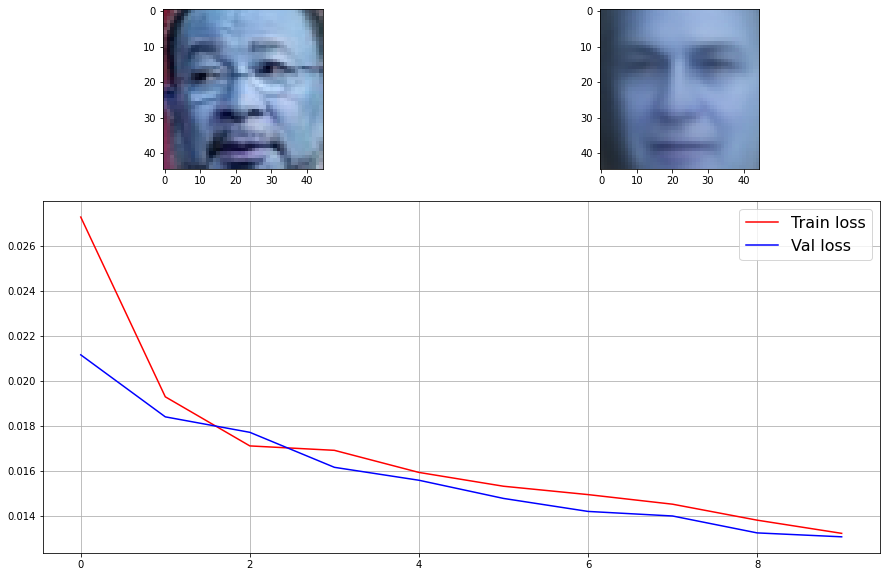

In [24]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
val_log = []
train_log = []
for ep in range(10):
    n_batches = 0
    err = 0
    for X_batch in yield_batch(X_train, 200):
        err += train_fn(X_batch)
        n_batches += 1
    train_log.append(err / n_batches)
    n_batches = 0
    err = 0
    for X_batch in yield_batch(X_val, 200):
        err += test_loss(X_batch)
        n_batches += 1
    val_log.append(err / n_batches)
    clear_output(True)
    
    plt.figure(figsize=(15,10))
    ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 4), (0, 2), colspan=2)
    ax3 = plt.subplot2grid((3, 4), (1, 0), colspan=4, rowspan=2)
    
    ind = np.random.randint(X_val.shape[0])
    ax1.imshow(X_val[ind].reshape((image_h, image_w, 3)), 
               cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    ax2.imshow(test_fn([X_val[ind]]).reshape((image_h, image_w, 3)), 
               cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    
    ax3.plot(train_log, 'r')
    ax3.plot(val_log, 'b')
    ax3.grid(True)
    ax3.legend(('Train loss', 'Val loss'), loc=0, fontsize=16);
    plt.show()

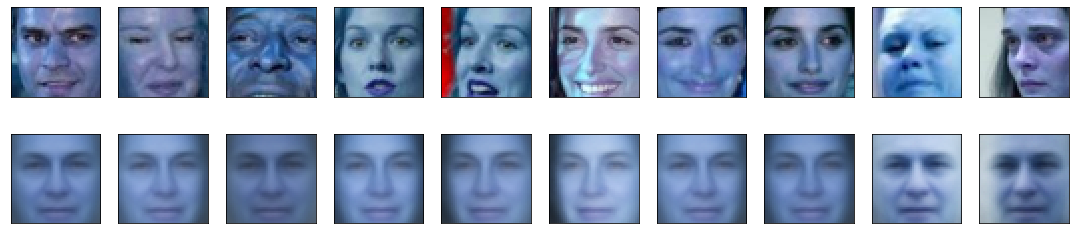

In [26]:
present(np.vstack((X_val[:10], test_fn(X_val[:10]))), image_h, image_w, n_row=2, n_col=10)

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

In [28]:
import numpy as np

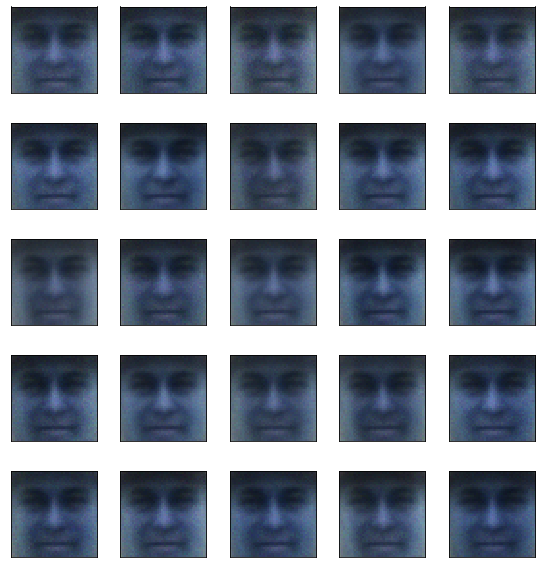

In [29]:
z = np.random.randn(25, dimZ)*0.5
z_sample = T.matrix()
hidden_state = lasagne.layers.InputLayer([None, 100], z_sample)
decoder = lasagne.layers.DenseLayer(hidden_state, HU_decoder, W=las_dec.W, b=las_dec.b)
output_layer = lasagne.layers.DenseLayer(decoder, HU_decoder, W=las_out.W, b=las_out.b, 
                                        nonlinearity=lasagne.nonlinearities.sigmoid)

generated_x = lasagne.layers.get_output(output_layer)
output = theano.function([z_sample], generated_x)(np.asarray(z, dtype=theano.config.floatX))
present(output, image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [30]:
dimZ = 100

In [31]:
import lasagne
import GS
input_X = T.matrix("X")
input_shape = [None,image_h*image_w*3]
relu_shift = 10
las_input = lasagne.layers.InputLayer(input_shape, input_X)
las_enc_hid = lasagne.layers.DenseLayer(las_input, HU_encoder, nonlinearity=T.nnet.softplus)
las_enc_mu = lasagne.layers.DenseLayer(las_enc_hid, dimZ, nonlinearity=None)
las_enc_logsigma = lasagne.layers.DenseLayer(las_enc_hid, dimZ, nonlinearity=None)

las_Z = GS.GaussianSampleLayer(las_enc_mu, las_enc_logsigma)

las_dec_hid = lasagne.layers.DenseLayer(las_Z, HU_decoder, nonlinearity=T.nnet.softplus)
las_dec_mu = lasagne.layers.DenseLayer(las_dec_hid, input_shape[1], nonlinearity=None)
las_dec_logsigma = lasagne.layers.DenseLayer(las_dec_hid, input_shape[1],
        nonlinearity=lambda a: T.nnet.relu(a + relu_shift) - relu_shift)
las_output = GS.GaussianSampleLayer(las_dec_mu, las_dec_logsigma)

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [32]:
def KL_divergence(mu, logsigma):
    return -0.5 * T.sum(2 * logsigma - T.sqr(mu) - T.exp(2 * logsigma))

def log_likelihood(x, mu, logsigma):
    return T.sum(-logsigma - 0.5 * T.sqr(x - mu) / T.exp(2 * logsigma))

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return -KL_divergence(mu, logsigma)+log_likelihood(x, mu, logsigma)

In [33]:
hid_mu, hid_ls, dec_mu, dec_ls = lasagne.layers.get_output([las_enc_mu, las_enc_logsigma, las_dec_mu, las_dec_logsigma])

In [34]:
loss = KL_divergence(hid_mu, hid_ls) - log_likelihood(input_X, dec_mu, dec_ls)
pred = lasagne.layers.get_output(las_output, deterministic=True)

params = lasagne.layers.get_all_params(las_output, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=1e-4)

train_fn = theano.function([input_X], loss, updates=updates)
test_fn = theano.function([input_X], loss)
prediction = theano.function([input_X], pred)

And train the model:

In [35]:
val_log = []
train_log = []
def yield_batch(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

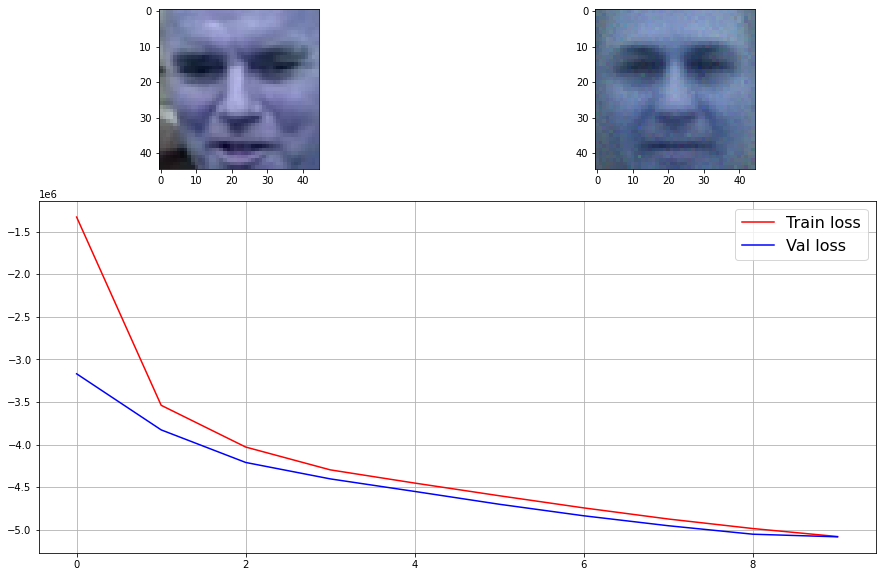

In [36]:
# train your autoencoder
# visualize progress in reconstruction and loss decay
for ep in range(10):
    n_batches = 0
    err = 0
    for X_batch in yield_batch(X_train, 500):
        err += train_fn(X_batch)
        n_batches += 1
    train_log.append(err / n_batches)
    n_batches = 0
    err = 0
    for X_batch in yield_batch(X_val, 500):
        err += test_fn(X_batch)
        n_batches += 1
    val_log.append(err / n_batches)
    clear_output(True)
    
    plt.figure(figsize=(15,10))
    ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 4), (0, 2), colspan=2)
    ax3 = plt.subplot2grid((3, 4), (1, 0), colspan=4, rowspan=2)
    
    ind = np.random.randint(X_val.shape[0])
    ax1.imshow(X_val[ind].reshape((image_h, image_w, 3)), 
               cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    ax2.imshow(prediction([X_val[ind]]).reshape((image_h, image_w, 3)), 
               cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    
    ax3.plot(train_log, 'r')
    ax3.plot(val_log, 'b')
    ax3.grid(True)
    ax3.legend(('Train loss', 'Val loss'), loc=0, fontsize=16);
    plt.show()

And finally sample from VAE.

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

In [37]:
smiling = attrs.Smiling.values

In [38]:
ind = np.argsort(smiling)

In [39]:
ind

array([11571,  1234,  7506, ..., 13034,  1816,  8643])

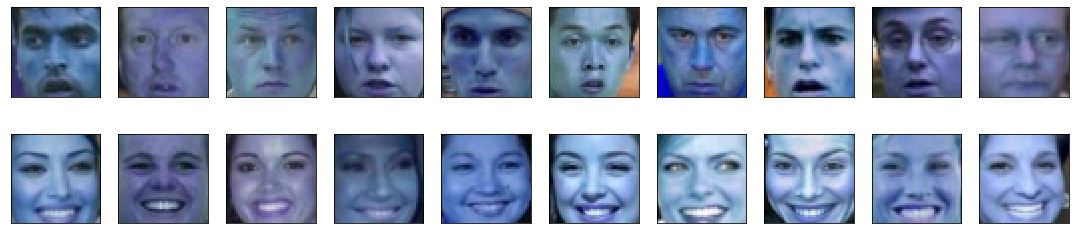

In [40]:
present(np.vstack((data[ind[:10]], data[ind[-10:]])), image_h, image_w, n_row=2, n_col=10)

In [42]:
X = np.float32(data / 255)
z_repr = theano.function([input_X], lasagne.layers.get_output(las_enc_mu))
mean = z_repr(X[ind[-50:]].reshape(50, -1)).mean(axis=0)
mean -= z_repr(X[ind[:50]].reshape(50, -1)).mean(axis=0)
z_sample = T.matrix()

inp_layer = lasagne.layers.InputLayer([None, dimZ], z_sample)
hid_state = lasagne.layers.DenseLayer(inp_layer, HU_decoder, nonlinearity=T.nnet.softplus,
                                      W=las_dec_hid.W, b=las_dec_hid.b)
decoder_mu = lasagne.layers.DenseLayer(hid_state, input_shape[1], nonlinearity=None, W=las_dec_mu.W, b=las_dec_mu.b)
gen_fn = theano.function([z_sample], lasagne.layers.get_output(decoder_mu))
img = X[ind[10]]
smiling_faces = z_repr(img.reshape(1,-1))
generated = []
for c in range(6):
    smiling_faces += mean * c * 0.1
    generated.append(gen_fn(smiling_faces))

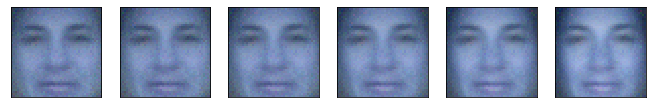

In [43]:
present(generated, image_h, image_w, n_row=1, n_col=6)

In [44]:
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [45]:
color_face=attrs['Color Photo'].values

In [46]:
color_face

array([3.09770263624, 2.99707627363, 1.7068970101899998, ...,
       3.93787482857, 5.77900734964, 1.60391648845], dtype=object)

In [47]:
ind = np.argsort(color_face)

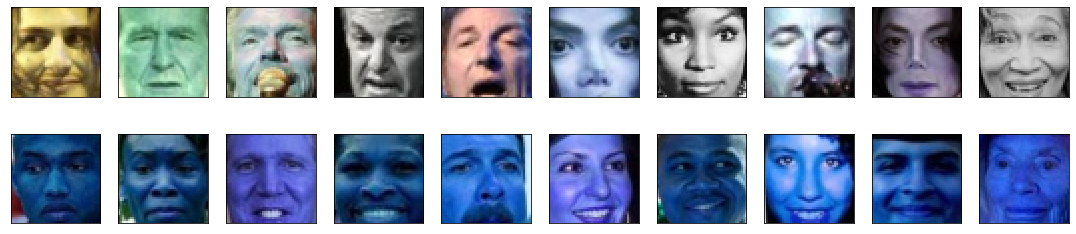

In [48]:
present(np.vstack((data[ind[:10]], data[ind[-10:]])), image_h, image_w, n_row=2, n_col=10)


In [52]:
X = np.float32(data / 255)
z_repr = theano.function([input_X], lasagne.layers.get_output(las_enc_mu))
mean = z_repr(X[ind[-50:]].reshape(50, -1)).mean(axis=0)
mean -= z_repr(X[ind[:50]].reshape(50, -1)).mean(axis=0)
z_sample = T.matrix()

inp_layer = lasagne.layers.InputLayer([None, dimZ], z_sample)
hid_state = lasagne.layers.DenseLayer(inp_layer, HU_decoder, nonlinearity=T.nnet.softplus,
                                      W=las_dec_hid.W, b=las_dec_hid.b)
decoder_mu = lasagne.layers.DenseLayer(hid_state, input_shape[1], nonlinearity=None, W=las_dec_mu.W, b=las_dec_mu.b)
gen_fn = theano.function([z_sample], lasagne.layers.get_output(decoder_mu))
img = X[ind[10]]
color_faces = z_repr(img.reshape(1,-1))
generated = []
for c in range(6):
    color_faces += mean * c * 0.1
    generated.append(gen_fn(color_faces))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


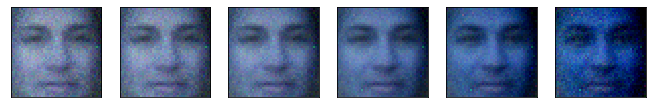

In [53]:
present(generated, image_h, image_w, n_row=1, n_col=6)

In [54]:
attr_women=attrs['Attractive Woman'].values

In [55]:
ind = np.argsort(attr_women)

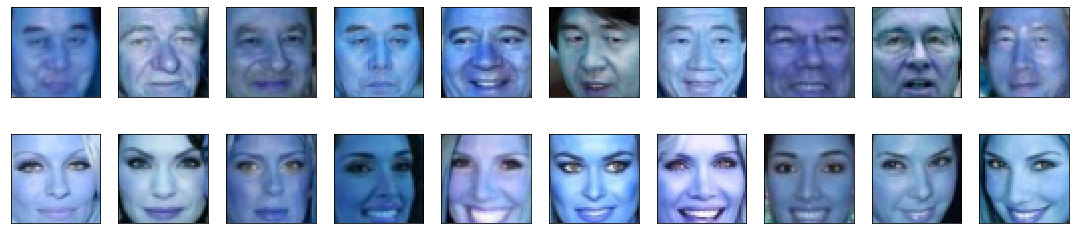

In [56]:
present(np.vstack((data[ind[:10]], data[ind[-10:]])), image_h, image_w, n_row=2, n_col=10)


In [57]:
X = np.float32(data / 255)
z_repr = theano.function([input_X], lasagne.layers.get_output(las_enc_mu))
mean = z_repr(X[ind[-50:]].reshape(50, -1)).mean(axis=0)
mean -= z_repr(X[ind[:50]].reshape(50, -1)).mean(axis=0)
z_sample = T.matrix()

inp_layer = lasagne.layers.InputLayer([None, dimZ], z_sample)
hid_state = lasagne.layers.DenseLayer(inp_layer, HU_decoder, nonlinearity=T.nnet.softplus,
                                      W=las_dec_hid.W, b=las_dec_hid.b)
decoder_mu = lasagne.layers.DenseLayer(hid_state, input_shape[1], nonlinearity=None, W=las_dec_mu.W, b=las_dec_mu.b)
gen_fn = theano.function([z_sample], lasagne.layers.get_output(decoder_mu))
img = X[ind[10]]
attr_woman = z_repr(img.reshape(1,-1))
generated = []
for c in range(6):
    attr_woman += mean * c * 0.1
    generated.append(gen_fn(attr_woman))

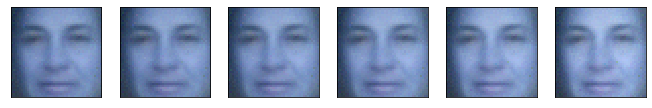

In [58]:
present(generated, image_h, image_w, n_row=1, n_col=6)